In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import kurtosis

from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor



In [2]:
# Define the directory of the train data
from pathlib import Path
train_data_dir = Path('train')

## a. Load the first sample (0.txt) and visualize the acceleration in the x direction of bearing 4. Compare this visualization to 3 other samples from different degradation stages.

In [18]:
# Inspect the first file's columns
def data_(file_name):
    sample_file = os.path.join(train_data_dir, file_name)
    bearing_data = pd.read_csv(sample_file, delimiter=';')    

    return bearing_data

bearing_data_0 = data_('0.csv')
bearing_data_0

,b1x,b1y,b4x,b4y
0,-0.022,-0.039,-0.129,-0.142
1,-0.105,-0.017,-0.115,-0.122
2,-0.183,-0.098,-0.171,-0.071
3,-0.178,-0.161,-0.112,-0.078
4,-0.208,-0.129,-0.063,-0.066
...,...,...,...,...
20475,-0.022,-0.142,-0.134,-0.093
20476,0.024,-0.156,-0.227,-0.132
20477,-0.193,-0.303,-0.151,0.007
20478,-0.115,0.076,-0.151,-0.005


## b. Make a function that, given an index, loads the corresponding sample and returns mean, standard deviation, and root mean squared of both x and y acceleration. 

In [17]:
def features_acceleration_data(sample, index=-1):
    # sample = data_(file_name)

    # Make a function that, given an index, loads the corresponding sample and returns mean, standard deviation,
    # and root mean squared of both x and y acceleration.
    if index == -1:
        pass

    elif index or index == 0:
        print(f"Corresponding Sample: ({sample.loc[index, 'b4x']},{sample.loc[index, 'b4y']})")
    
        # Calculates the mean, standard deviation, and
        # root mean squared of both x and y acceleration
        # sample_x = sample.b4x.iloc[index] 
        # sample_y = sample.b4y.iloc[index] 

    mean_x = sample.b4x.mean()
    mean_y = sample.b4y.mean()
    std_x = sample.b4x.std()
    std_y = sample.b4y.std()
    rms_x = np.sqrt(np.mean(sample.b4x**2))
    rms_y = np.sqrt(np.mean(sample.b4x**2))
    
    # First feature to add: Spectral Flatness
    _, Pxx_x = welch(sample.b4x)
    spectral_flatness_x = np.exp(np.mean(np.log(Pxx_x))) / np.mean(Pxx_x)
    _, Pxy_y = welch(sample.b4y)
    spectral_flatness_y = np.exp(np.mean(np.log(Pxy_y))) / np.mean(Pxy_y)

    # Second feature to add: Kurtosis
    kurtosis_x = kurtosis(sample.b4x)
    kurtosis_y = kurtosis(sample.b4y)

    features = {
        'mean_x': mean_x,
        'mean_y': mean_y,
        'std_x': std_x,
        'std_y': std_y,
        'rms_x': rms_x,
        'rms_y': rms_y,
        'spectral_flatness_x': spectral_flatness_x,
        'spectral_flatness_y': spectral_flatness_y,
        'kurtosis_x': kurtosis_x,
        'kurtosis_y': kurtosis_y
    }
    return features
    
features_acceleration_data(data_('0.csv'))

{'mean_x': -0.09096875,
 'mean_y': -0.094235205078125,
 'std_x': 0.06008602164049359,
 'std_y': 0.0663816272503547,
 'rms_x': 0.10902048975995292,
 'rms_y': 0.10902048975995292,
 'spectral_flatness_x': 0.5962608450036389,
 'spectral_flatness_y': 0.8044983999172042,
 'kurtosis_x': 0.7902499085116994,
 'kurtosis_y': 1.8079901941922039}

Why Spectral Flatness and Kurtosis? (Visualization Check)

In [19]:
# To simplify the visualization, we made a function.
def viz_acceleration_bearing_data(csv_data, y_column):
    bearing_data = data_(csv_data)
    y0 = bearing_data[y_column]
    _, Pxx = welch(bearing_data[y_column])
    spectral_flatness = np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)
    kurtosis_ = kurtosis(bearing_data[y_column])

    plt.figure(figsize=(10, 8))
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.title(f'Acceleration in x-direction of Bearing 4 (Source = {csv_data})')
    plt.gcf().text(0.85, 0.17, f'Spectral Flatness: {spectral_flatness:.4f}', fontsize=10, horizontalalignment='right')
    plt.gcf().text(0.85, 0.20, f'Kurtosis: {kurtosis_:.4f}', fontsize=10, horizontalalignment='right')

    plt.hist(y0)


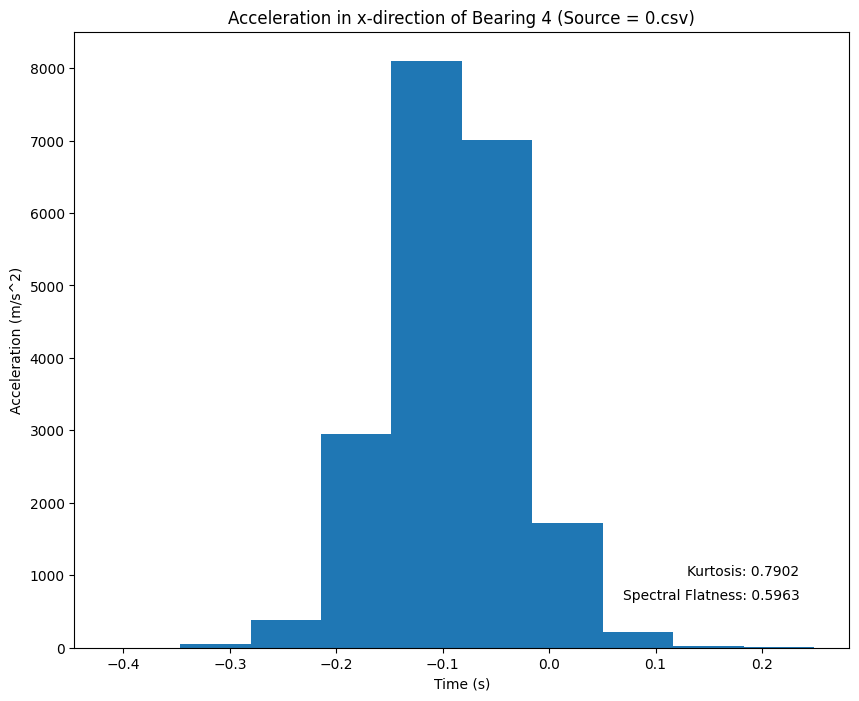

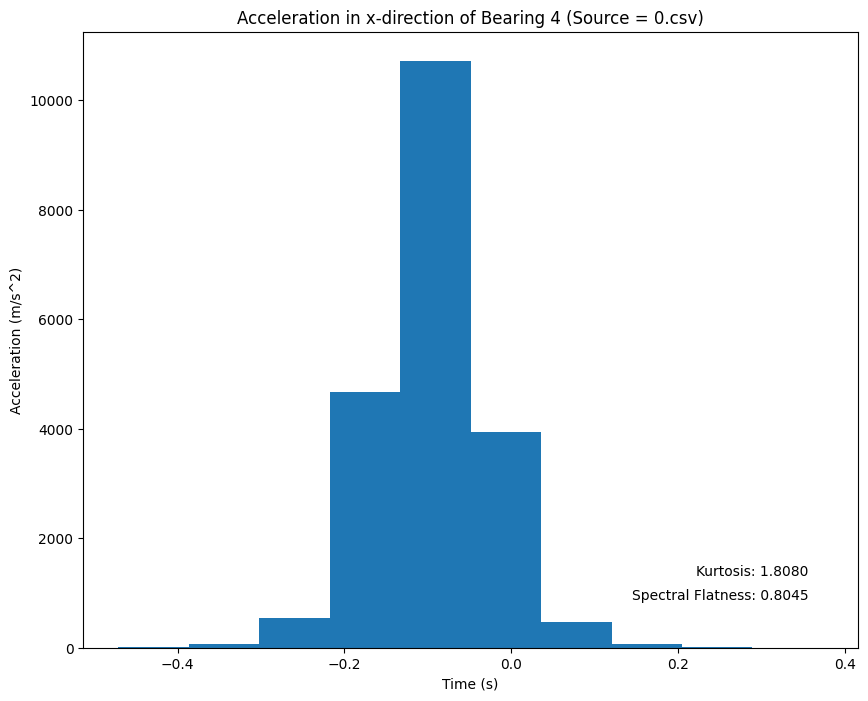

In [21]:
# Load the first sample (0.txt) and visualize the acceleration in the x direction of bearing 4. 
viz_acceleration_bearing_data('0.csv', 'b4x')
viz_acceleration_bearing_data('0.csv', 'b4y')

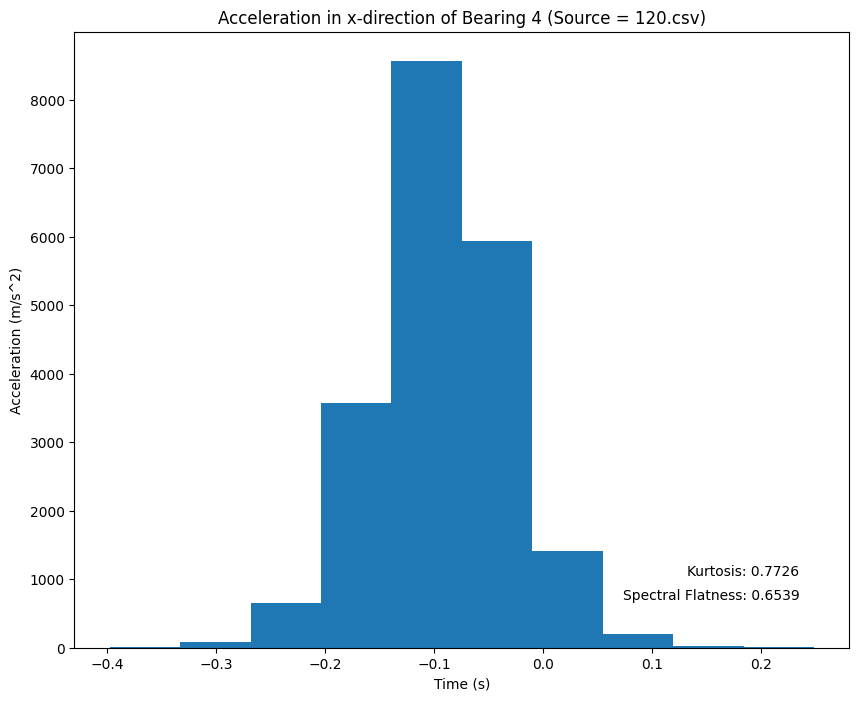

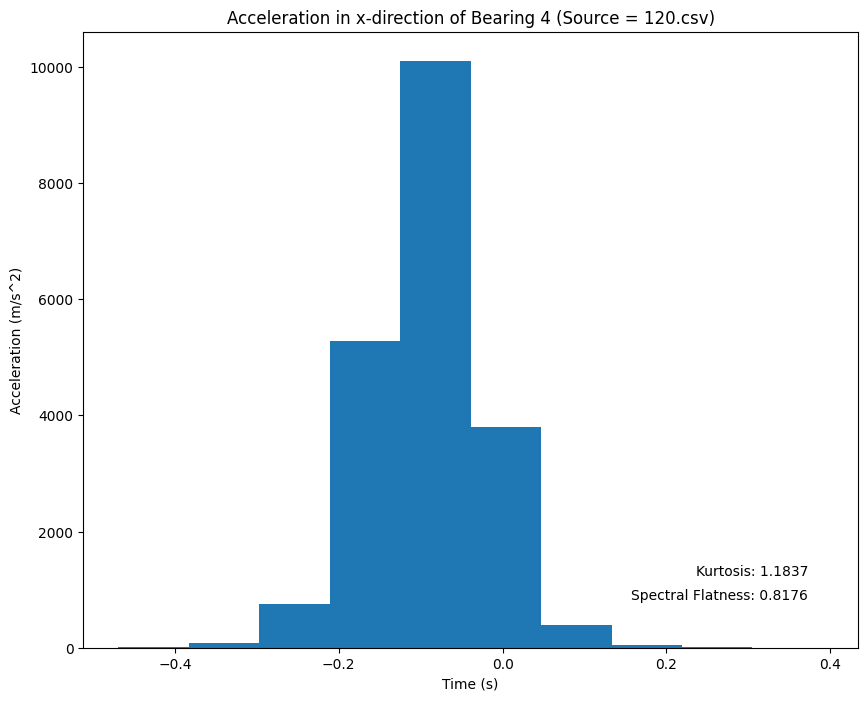

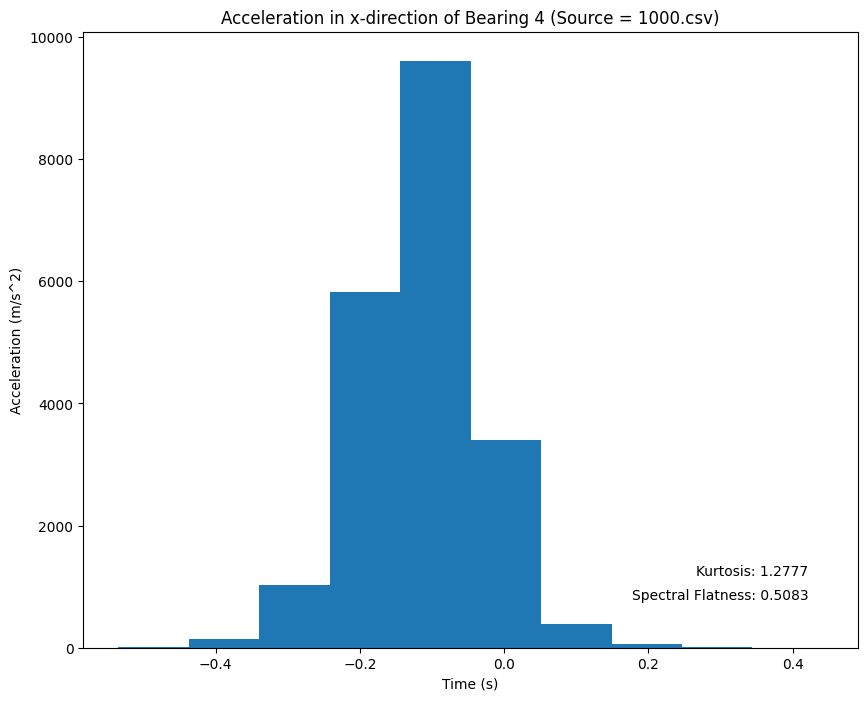

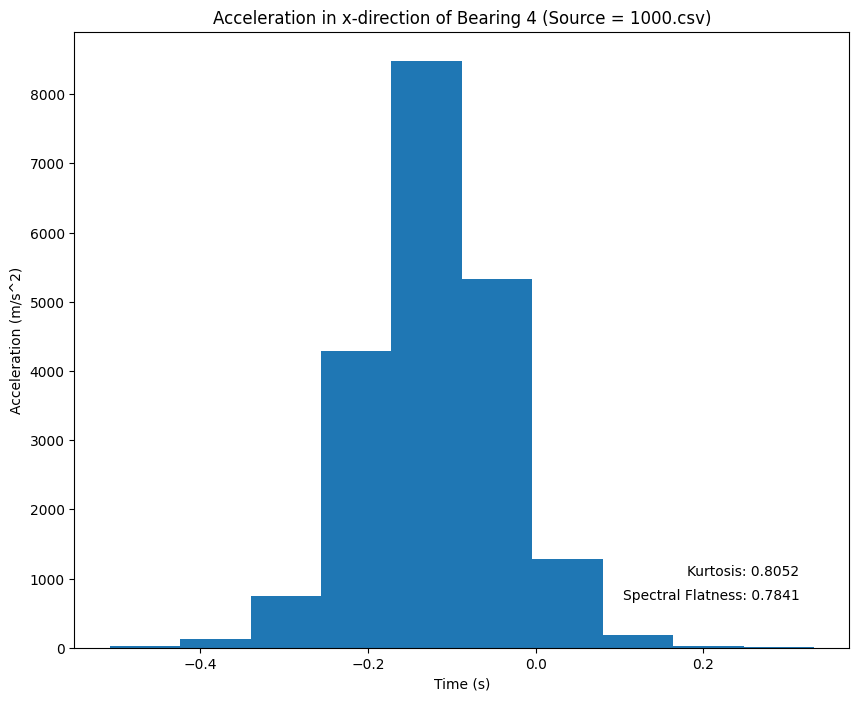

In [22]:
# Visualizations are not explaning anything???

# Compare this visualization to 3 other samples from different degradation stages.
viz_acceleration_bearing_data('120.csv', 'b4x')
viz_acceleration_bearing_data('120.csv', 'b4y')
plt.show()
viz_acceleration_bearing_data('1000.csv', 'b4x')
viz_acceleration_bearing_data('1000.csv', 'b4y')
plt.show()
# viz_acceleration_bearing_data('1260.csv', 'b4x')

# As we can see, the kurtosis value

## c. Apply the function from b. to the entire dataset and store your results in a dataframe. Perform some explanatory data analysis to get some insight on which classification models might be suitable for predicting the degradation stage.

In [23]:
# List to store feature data
feature_list = []

for file_name in os.listdir(train_data_dir):
    # Calculate features
    features = features_acceleration_data(data_(file_name))
    
    if features:
        # Add the file name to the features
        features['file'] = file_name
        
        # Append the features to the list
        feature_list.append(features)

# Dataframe of the appended features
feature_df = pd.DataFrame(feature_list)
feature_df

,mean_x,mean_y,std_x,std_y,rms_x,rms_y,spectral_flatness_x,spectral_flatness_y,kurtosis_x,kurtosis_y,file
0,-0.090969,-0.094235,0.060086,0.066382,0.109020,0.109020,0.596261,0.804498,0.790250,1.807990,0.csv
1,-0.091260,-0.087946,0.059421,0.064746,0.108900,0.108900,0.584145,0.783668,1.234703,1.873189,1.csv
2,-0.077442,-0.092548,0.059237,0.066303,0.097500,0.097500,0.592749,0.779913,0.808053,1.520737,10.csv
3,-0.093076,-0.092855,0.063374,0.068734,0.112602,0.112602,0.641669,0.818774,0.553181,1.142888,100.csv
4,-0.114358,-0.120604,0.082444,0.082354,0.140977,0.140977,0.508304,0.784076,1.277742,0.805210,1000.csv
...,...,...,...,...,...,...,...,...,...,...,...
288,-0.114863,-0.114734,0.094786,0.100516,0.148921,0.148921,0.542126,0.728396,2.247974,1.447407,1257.csv
289,-0.114929,-0.114242,0.092487,0.101532,0.147520,0.147520,0.566459,0.715986,2.040679,1.348293,1258.csv
290,-0.115394,-0.115230,0.093688,0.099987,0.148636,0.148636,0.557057,0.736812,1.501953,1.103627,1259.csv
291,-0.092892,-0.093317,0.062946,0.068423,0.112209,0.112209,0.643962,0.813113,0.789755,1.334046,126.csv


In [26]:
# Before performing exploratory data analysis,
# we will firstly split the data
X = bearing_data_0.b4x.values.reshape(-1, 1)
y = bearing_data_0.b4y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [27]:
rf = RandomForestRegressor(random_state=42)
gcv_rf = GridSearchCV(rf, param_grid={
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 10, 20, 40]},
    cv = 3, n_jobs = -1,
    verbose=3, scoring = 'neg_mean_absolute_error')

gcv_rf.fit(X_train, y_train)

best_rf = gcv_rf.best_estimator_

print('Best hyperparameter(s):', gcv_rf.best_params_)
print('Best score:', gcv_rf.best_score_)
print('Best model:', best_rf)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best hyperparameter(s): {'max_depth': 4, 'min_samples_split': 40, 'n_estimators': 200}
Best score: -0.04952860251144094
Best model: RandomForestRegressor(max_depth=4, min_samples_split=40, n_estimators=200,
                      random_state=42)


## d. We have used the standard deviation and the rms. However, these features are highly correlated. Explain why these features are highly correlated (either in words or mathematically).

In [28]:
# Firstly we can examine what the formula is for both features:
# RMS = sqrt( (1/N) * sum(x_i^2) )
# Stdev = sqrt( (1/N) * sum((x_i - mean)^2) )

# While they both aim to calculate the variability of the data, they do it slightly differently
# since Stdev considered the data's mean and RMS does not.

# However, these features will become increasingly similar as the mean approaches zero
# Where the mean is approximately zero, (x_i - mean) in Stdev becomes x_i -- just like in RMS.

# And small mean values are the case in this data, as we can see from the results of the features function in b.
# Therefore, it makes sense why these values are highly correlated.